<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/TumoriBenigni_Maligni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerie

In [1]:
###LIBRERIE 
import numpy as np 
import pandas as pd 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend




In [2]:
#per i crash casuali del kernel nella k-fold
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.10

# Inserimento dei dati


In [3]:
###DATA PREPROCESSING 
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Colab/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Colab/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Colab/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Colab/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
print("test maligni caricati")

Mounted at /content/drive
train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


##Creo le Lables


In [4]:

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

##Merge and Shuffle


In [5]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


#Shuffle
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

##Visualizzo le immagini

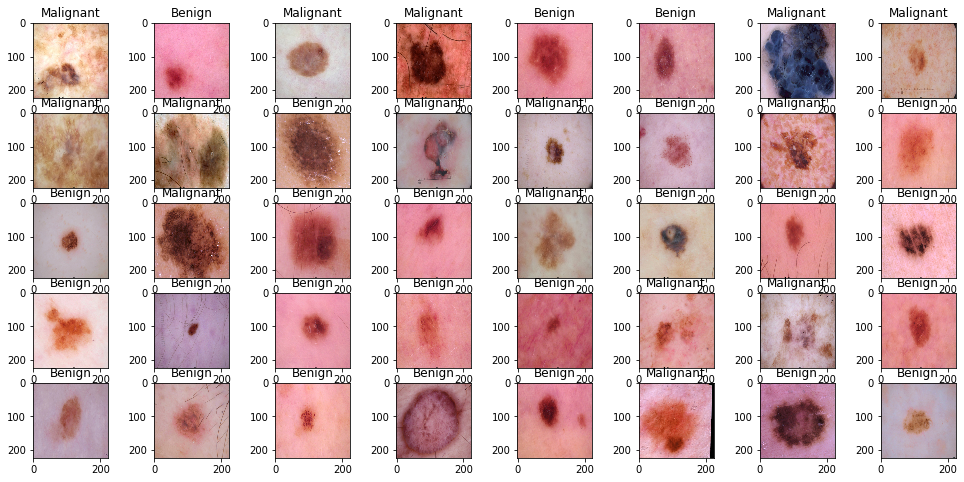

In [6]:
fig=plt.figure(figsize=(17, 8))
columns = 8
rows = 5

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

##Lables-->Categorical

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

##Normalizzazione

In [8]:
X_train = X_train/255
X_test = X_test/255
X_train.shape

(2637, 224, 224, 3)

##Modello

In [9]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def Addestramento(input_shape, lr, numclassi, optim, activation_Dense): 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding = 'same',activation = 'relu', input_shape = input_shape,kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))#metto questo stato di dropout per evitare un overfitting della rete 
    model.add(layers.Conv2D(64, (3,3), padding = 'same' ,activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.40))
    model.add(layers.Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numclassi, activation='softmax'))
    #Scegli l'ottimizzatore
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    else:
        optimizer = Adam(lr=lr)
    model.summary()

    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
    return model


##Addestramento

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

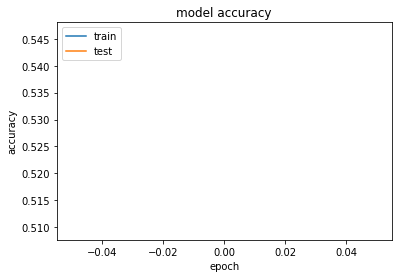

Text(0.5, 1.0, 'model loss')

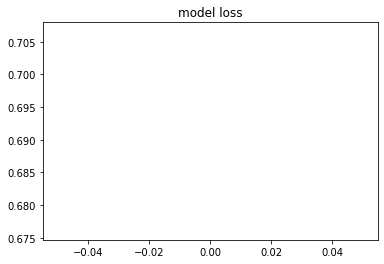

In [10]:
model = Addestramento((224,224,3), 1e-5, 2,'relu', 'adam')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)

epochs = 1
batch_size = 64

history = model.fit(X_train, y_train, validation_split=0.2, epochs= epochs , batch_size= batch_size,callbacks=[learning_rate_reduction], verbose=1)
#Lista di tutta la storia fatta dai dati 
print(history.history.keys())
# storia accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#storia loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

##K-fold


In [ ]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
print(f'shape degli input = {inputs.shape}')
print(f'shape dei target = {targets.shape}')

#4 k fold
kfold = KFold(n_splits=4, shuffle=True)
print(f'values kfold = {kfold}')

#dove metto gli score
acc_per_fold = []
loss_per_fold = []
fold_no = 1

#epoche e batch
epochs = 1
batch_size = 64

for train, test in kfold.split(inputs, targets):

    model = Addestramento((224,224,3), 1e-5, 2,'relu', 'adam')
    print("rete caricata")
    
    #Addestro il modello su una parte dei dati di train
    model.fit(inputs[train], targets[train], epochs=epochs, batch_size=batch_size, verbose=1)
    print('fine addestramento rete')
    
    #score del modello in percentuale
    scores = model.evaluate(inputs[test], targets[test], verbose=1)
    print(f'Score per fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

#Media degli score
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Media degli scores per tutte le folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

shape degli input = (3297, 224, 224, 3)
shape dei target = (3297, 2)
values kfold = KFold(n_splits=4, random_state=None, shuffle=True)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 64)    

#####Qua mi da il kernel si è arrestato in modo anomalo, senza un trace non riesco a debbuggare la cosa, o è il codice che non funziona o ho un problema con colab ma non riesco a capire
#####1)Dai trace di print, fa crash quando deve fare il fit della rete 